In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'F:\\projects\\generative-models\\examples\\torch_autoencoder'

In [3]:
%cd ../..
%pwd

F:\projects\generative-models


'F:\\projects\\generative-models'

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

from gempy.torch.encoder import ConvEncoder
from gempy.torch.decoder import ConvDecoder
from gempy.torch.auto_encoder import AutoEncoder

import matplotlib.pyplot as plt

In [5]:
def get_MNIST(batch_size, dataset_directory, dataloader_workers, source='MNIST'):
    # Prepare dataset for training
    train_transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    
    data_source = getattr(torchvision.datasets, source)
    
    train_dataset = data_source(root=dataset_directory, train=True, download=True, transform=train_transformation)

    test_dataset =  data_source(root=dataset_directory, train=False, download=True, transform=train_transformation)

    # Prepare Data Loaders for training and validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               pin_memory=True, num_workers=dataloader_workers)

    # Prepare Data Loaders for training and validation
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                              pin_memory=True, num_workers=dataloader_workers)

    return train_dataset, test_dataset, train_loader, test_loader

In [6]:
BATCHSIZE = 32
LEARNINGRATE = 0.0005

train_dataset, test_dataset, train_loader, test_loader = get_MNIST(BATCHSIZE, 
                                                                   'examples/torch_autoencoder/data/', 
                                                                   4,
                                                                   'CIFAR10',  # 'MNIST'
                                                                  )

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32]) tensor(0.) tensor(1.)


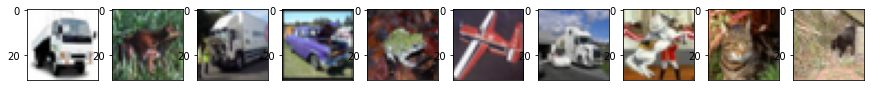

In [7]:
f, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax in axes:
    tensor = train_dataset[np.random.randint(len(train_dataset))][0]
    ax.imshow(tensor.detach().numpy().transpose(1,2,0), cmap='binary')
    ax.set_xticks([]); ax.set_yticks

print(train_dataset[0][0].shape, train_dataset[0][0].min(), train_dataset[0][0].max())

In [8]:
input_dim = (3, 32, 32)  # (1, 28, 28)
z_dim = 128   #(2, )
z_labels = ('z', )

In [9]:
device = 'cpu'
if torch.cuda.is_available():
    print (f'GPU available')
    device = 'cuda'

x_random = torch.randn(1, *input_dim)
x_random = x_random.to(device)

GPU available


In [10]:
encoder = ConvEncoder(
    input_shape=input_dim,
    #filters=(32, 64, 64, 64),
    filters=(32, 64, 64, 128),
    kernel_size=(3, 3, 3, 3),
    strides=(1, 2, 2, 1),
    activation='leaky_relu',
    latent_dim=z_dim,
    latent_labels=z_labels,
    latent_activation=None,
    use_dropout=0.8,
)

encoer = encoder.to(device)
encoder

TypeError: __init__() missing 1 required positional argument: 'kernels_size'

In [ ]:
print('Encoder:')
for l in encoder.conv_stack:
    print('- layer activation: ', l[-2])

In [ ]:
def show_latent(data_loader=test_loader):
    y_latent = []
    y_labels = []
    for batch_features, batch_labels in data_loader:
        batch_features = batch_features.to(device)
        y = encoder(batch_features)[0].detach().cpu().numpy()
        y_latent.extend(y)
        y_labels.extend(batch_labels.numpy())

    y_latent = np.asarray(y_latent)
    y_labels = np.asarray(y_labels)
    
    digit_map = [y_labels == i for i in range(10)]
    
    plt.figure(figsize=(10,10))
    for i, where_i in enumerate(digit_map):
        selection = y_latent[where_i]    
        plt.scatter(*selection[...,:2].T, label=f'#{i}', alpha=0.5)
    plt.legend()
    
    return y_latent

In [ ]:
latent_space = show_latent()
print(f'{len(latent_space)} datapoints')

In [ ]:
decoder = ConvDecoder(
    latent_shape=z_dim,
    latent_upscale=(64, 7, 7),
    # filters=[64, 64, 32, 1],
    filters=[128, 64, 64, 64, 3],
    kernels_size=[3, 4, 5, 4, 3],
    strides=[1, 2, 1, 2, 1],
    activation=['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'sigmoid'],
    latent_merge=False,
    latent_activation=None,
    use_dropout=False
)

decoder = decoder.to('cuda')
decoder

In [ ]:
print('Decoder:')
for l in decoder.conv_stack:
    print('- layer activation: ', l[-2])

In [ ]:
auto_encoder = AutoEncoder(
    encoder=encoder,
    decoder=decoder,
)

auto_encoder = auto_encoder.to(device)
auto_encoder

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in auto_encoder.state_dict():
    print(param_tensor, "\t", auto_encoder.state_dict()[param_tensor].size())

In [ ]:
print('input shape     :', auto_encoder.encoder.conv_stack_shape_in)
print('latent shape     :', auto_encoder.encoder.conv_stack_shape_out)
print('z shape          :', z_dim)
print('output shape    :', auto_encoder.decoder.conv_stack_shape_out)

In [ ]:
y = auto_encoder(x_random)

print('latent space    :', encoder.latent_torch)
print('output shape    :', y.shape)


In [ ]:
# create an optimizer object
optimizer = torch.optim.Adam(auto_encoder.parameters(),  # link to AE parameters
                             lr=LEARNINGRATE)            # set learning rate

In [ ]:
# mean-squared error loss
criterion = torch.nn.MSELoss()

In [ ]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
epochs = 200
WINDOW = 5
STOPPING = 1e-6

loss_history = []
valid_history = []
variations = []

def early_stopping(loss_history, rate=1e-4, window=5):
    if len(loss_history) < window:
        return False
    
    if np.absolute(np.std(loss_history[-window:])) < rate:
        print(np.absolute(np.std(loss_history[-window:])))
        return True
    
    return False

for epoch in range(epochs):
    loss = 0
    valid = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = auto_encoder(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    for test_batch, _ in test_loader:
        test_batch = test_batch.to(device)
        outputs = auto_encoder(test_batch)
        test_loss = criterion(outputs, test_batch)
        valid += test_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    loss_history.append(loss)
                        
    valid = valid / len(test_loader)
    valid_history.append(valid)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, valid = {:.6f}".format(epoch + 1, epochs, loss, valid))
    
    if early_stopping(loss_history, rate=STOPPING, window=WINDOW):
        print(f"early stopping: could not improve validation of model in range {STOPPING} in {WINDOW} consecutive epochs")
        break

In [ ]:
plt.figure(figsize=(15, 5))
plt.semilogy(loss_history, marker='.', label='loss')
plt.semilogy(valid_history, marker='.', label='valid')
plt.xlabel('Epochs'); 
plt.ylabel('MSE loss')
plt.legend();

In [ ]:
y_latent = show_latent()

In [ ]:
y_latent_range = list({'min': li.min(), 'mean': li.mean(), 'max': li.max()} for li in y_latent.T)

In [ ]:
n = 10

z_rand = np.random.rand(n, *z_dim)
for i in range(z_rand.shape[-1]):
    range_i = (y_latent_range[i]['max'] - y_latent_range[i]['min'])
    offset_i = 0.5 - y_latent_range[i]['mean'] / range_i
    z_rand[..., i] -= offset_i
    z_rand[..., i] *= range_i
    
t_rand = torch.from_numpy(z_rand).float().to(device)
y_rand = auto_encoder.decoder(t_rand)
y_numpy = y_rand.detach().cpu().numpy()

tensor_choice = [np.random.randint(len(train_dataset)) for __ in range(n)]
train_subset = torch.utils.data.Subset(train_dataset, tensor_choice)
train_subloader = torch.utils.data.DataLoader(train_subset, batch_size=len(tensor_choice))

for tensors, __ in train_subloader:
    reconst = auto_encoder(tensors.to(device))

    f, axes = plt.subplots(3, n, figsize=(15, 5))
    for i, ax in enumerate(axes.T):
        ax[0].imshow(tensors[i].detach().numpy().transpose(1,2,0), cmap='binary')
        ax[1].imshow(reconst[i].detach().cpu().numpy().transpose(1,2,0), cmap='binary')

        ax[2].imshow(y_numpy[i].transpose(1,2,0), cmap='Blues')
        ax[0].set_xticks([]); ax[0].set_yticks([])
        ax[1].set_xticks([]); ax[1].set_yticks([])
        ax[2].set_xticks([]); ax[2].set_yticks([])

    axes[0][0].set_ylabel('MNIST');
    axes[1][0].set_ylabel('AE REC.');
    axes[2][0].set_ylabel('AE RAND');